In [1]:
import UtilityFunctions as uf
import cv2
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import itertools as itr

In [2]:
#Led off validation step
def led_off_frame_validation(vidpath, led_off_frames):
    validated_led_off = []
    cap = cv2.VideoCapture(vidpath)
    breaker = 0
    i = 0
    while breaker == 0:
        if i == len(led_off_frames):
            breaker = 1
        if breaker == 1:
            break
        f = led_off_frames[i]
        cap.set(cv2.CAP_PROP_POS_FRAMES, f)
        ret, frame = cap.read()
        frame = cv2.putText(frame, f'frame number {str(f)}', (100, 100), 1, 5, (255, 255, 0), 3)
        cv2.imshow('validation', frame)
        key = ord('a')
        while key not in [ord('q'), ord('k'), ord('s'), ord('b'), ord('z'), ord('x')]:
            key = cv2.waitKey(0)
            if key == ord('q'):
                breaker = 1
                break
            elif key == ord('k'):
                if not f in validated_led_off:
                    validated_led_off.append(f)
                i += 1
                break
            elif key == ord('s'):
                if f in validated_led_off:
                    validated_led_off.remove(f)
                i+=1
                break
            elif key == ord('b'):
                i = i - 1
                break
            elif key == ord('z'):
                if i != 0:
                    if led_off_frames[i - 1] != led_off_frames[i] - 1:
                        led_off_frames[i] = led_off_frames[i] - 1
                break
            elif key == ord('x'):
                if i != len(led_off_frames)-1:
                    if led_off_frames[i + 1] != led_off_frames[i] + 1:
                        led_off_frames[i] = led_off_frames[i] + 1
                break

    cap.release()
    cv2.destroyAllWindows()
    return validated_led_off

In [3]:
def compress_frames(led_off_frames_ndarry):
    clustered_off_frames = []
    if type(led_off_frames_ndarry) == type(np.array([])):
        led_off_frames = led_off_frames_ndarry.tolist()
    else:
        led_off_frames = led_off_frames_ndarry
    if len(led_off_frames) == 0:
        print('no frames in the list')
        return []
    clust_count = 0
    start_clust = 0
    end_clust = 0
    for c in range(len(led_off_frames)-1):
        if clust_count == 0:
            start_clust = led_off_frames[c]
            end_clust = 0
        if led_off_frames[c] == led_off_frames[c+1] - 1:
            clust_count += 1
            continue
        else:
            end_clust = led_off_frames[c]

        if start_clust == end_clust:
            clustered_off_frames.append(start_clust)
        elif end_clust > start_clust:
            clustered_off_frames.append(start_clust)
            clustered_off_frames.append(end_clust)
        clust_count = 0
    if clust_count != 0:
        clustered_off_frames.append(start_clust)
        clustered_off_frames.append(led_off_frames[c])

    clustered_off_frames.append(led_off_frames[-1])
    return clustered_off_frames

In [4]:
def compress_frames_corrected(led_off_frames_ndarry,bite):
    clustered_off_frames = []
    if type(led_off_frames_ndarry) == type(np.array([])):
        led_off_frames = led_off_frames_ndarry.tolist()
    else:
        led_off_frames = led_off_frames_ndarry
    if len(led_off_frames) == 0:
        print('no frames in the list')
        return []
    clust_count = 0
    start_clust = 0
    end_clust = 0
    for c in range(len(led_off_frames)-1):
        if clust_count == 0:
            start_clust = led_off_frames[c]
            end_clust = 0
        if led_off_frames[c] == led_off_frames[c+1] - 1:
            clust_count += 1
            continue
        else:
            end_clust = led_off_frames[c]

        if start_clust == end_clust:
            clustered_off_frames.append(start_clust)
        elif end_clust > start_clust:
            clustered_off_frames.append(start_clust+bite)
            clustered_off_frames.append(end_clust-bite)
        clust_count = 0
    if clust_count != 0:
        clustered_off_frames.append(start_clust)
        clustered_off_frames.append(led_off_frames[c])

    clustered_off_frames.append(led_off_frames[-1])
    return clustered_off_frames

In [5]:
def find_suspected_frames(vidname,frame_val,z_scores):
    #First we find a threshold to use:
    print(f'Trying out threshold values for {vidname}:')
    plt.figure(figsize=[30,10])
    plt.plot(frame_val[0],z_scores)
    thr_values = [-2,-3,-4,-5]
    thr_count_pairs = []
    for threshold in range(len(thr_values)):
        suspects_bool = z_scores < thr_values[threshold]
        suspects = frame_val[0][suspects_bool]
        #print(f'for a threshold of {thr_values[threshold]} - there are {len(suspects)} suspected frames')
        thr_count_pairs.append([thr_values[threshold],len(suspects)])
    threshold_to_use = float(input(f'For a threshold of {thr_count_pairs[0][0]} there are {thr_count_pairs[0][1]} frames\n'
                                   f'For a threshold of {thr_count_pairs[1][0]} there are {thr_count_pairs[1][1]} frames\n'
                                   f'For a threshold of {thr_count_pairs[2][0]} there are {thr_count_pairs[2][1]} frames\n'
                                   f'For a threshold of {thr_count_pairs[3][0]} there are {thr_count_pairs[3][1]} frames\n'
                                   f'Enter threshold to use:'))
    sus_bool = z_scores < threshold_to_use
    plt.axhline(threshold_to_use, linewidth=3, color='r')
    plt.title(f'{vidname}, threshold= {threshold_to_use}', color='w',fontsize=40 )
    return frame_val[0][sus_bool] , threshold_to_use

In [6]:
#I need a buffed up suspect list - this is the function definition
def suspect_list_buffer(suspect_list,vidnames,frame_val_list,buff_amount):
    buffed_list = []
    for vid in range(len(vidnames)):
        buff = []
        for suspect in suspect_list[vid]:
            if int(suspect-buff_amount) > 0 & int(suspect+buff_amount)< len(frame_val_list[vid][0]):
                for i in itr.islice(frame_val_list[vid][0], int(suspect-buff_amount), int(suspect+buff_amount)):
                    if i not in buff:
                        buff.append(i)
        buffed_list.append(buff)
    buffed_array = np.array(buffed_list)
    return buffed_array

In [4]:
#list videos for analysis and produce vidnames
vid_paths = [
    r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_L\AzulaTrial5_30_12L.mp4',
    r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_R\AzulaTrial5_30_12.mp4'
            ]
vidnames = []
for vid in vid_paths:
    vidname = vid.split(sep="\\") ; vidname = vidname[len(vidname)-1]; vidname=vidname.split(sep='.') ; vidname=vidname[0]
    vidnames.append(vidname)
print(vidnames)

['AzulaTrial5_30_12L', 'AzulaTrial5_30_12']


In [5]:
frame_val_list = []
for vid in vid_paths:
    print(f'working on video {vid}')
    frame_val = uf.arena_video_initial_thr(vid, 30, show_frames=True)
    frame_val_list.append(frame_val)
print(f'done, frame_val_list contains {len(frame_val_list)} objects',flush=True)


working on video D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\Trial_3_L\AzulaTrial5_30_12L.mp4


KeyboardInterrupt: 

In [9]:
#produce Z and MAD values of the videos
z_list = []
mad_list = []
for vid in frame_val_list:
    mad = stats.median_abs_deviation(vid[1])
    mad_scores = np.array(vid[1])
    mad_scores= np.sqrt((mad_scores - mad)**2)
    zscores = stats.zscore(vid[1])
    z_list.append(zscores)
    mad_list.append(mad_scores)

In [3]:
# Here we find suspected frames (Based on Z scores)
suspect_list = []
threshold_list = []
for vid in range(len(vidnames)):
    suspects , thr_for_list = find_suspected_frames(vidnames[vid],frame_val_list[vid],z_list[vid])
    suspect_list.append(suspects)
    threshold_list.append(thr_for_list)

NameError: name 'vidnames' is not defined

In [11]:
print(len(suspect_list[0]))
print(len(suspect_list[1]))

259
248


In [12]:
cluster_list = []
for vid in range(len(vidnames)):
    clusters = compress_frames_corrected(suspect_list[vid],0)
    cluster_list.append(clusters)
    print(f'video {vidnames[vid]} has {len(clusters)} frames to go through manually')


video AzulaTrial5_30_12L has 39 frames to go through manually
video AzulaTrial5_30_12 has 37 frames to go through manually


In [13]:
validated_off_list = []
for vid in range(len(vidnames)):
    validated_off_list.append(led_off_frame_validation(vid_paths[vid], cluster_list[vid]))

In [14]:
mutual_validated = set(validated_off_list[0])
for l in validated_off_list[1:-1]:
    mutual_validated = mutual_validated & set(l)
mutual_validated

{243.0,
 327.0,
 441.0,
 442.0,
 459.0,
 460.0,
 2191.0,
 2198.0,
 5561.0,
 5569.0,
 8900.0,
 8908.0,
 12220.0,
 12228.0,
 15745.0,
 15753.0,
 19230.0,
 19239.0,
 22457.0,
 22465.0,
 25876.0,
 25883.0,
 29220.0,
 29228.0,
 32683.0,
 32691.0,
 36122.0,
 36130.0,
 39455.0,
 39463.0,
 42900.0,
 42907.0,
 46187.0,
 46195.0,
 49655.0,
 49662.0,
 52842.0,
 52848.0,
 52850.0}

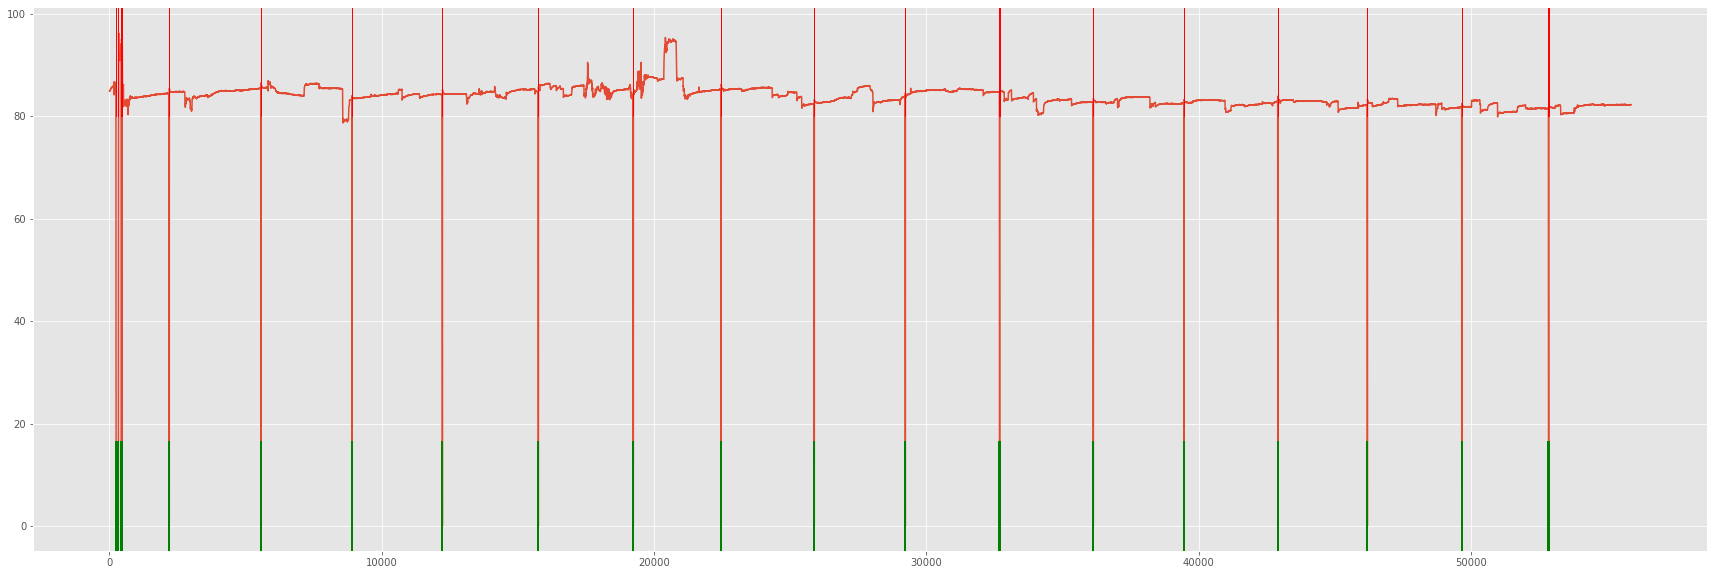

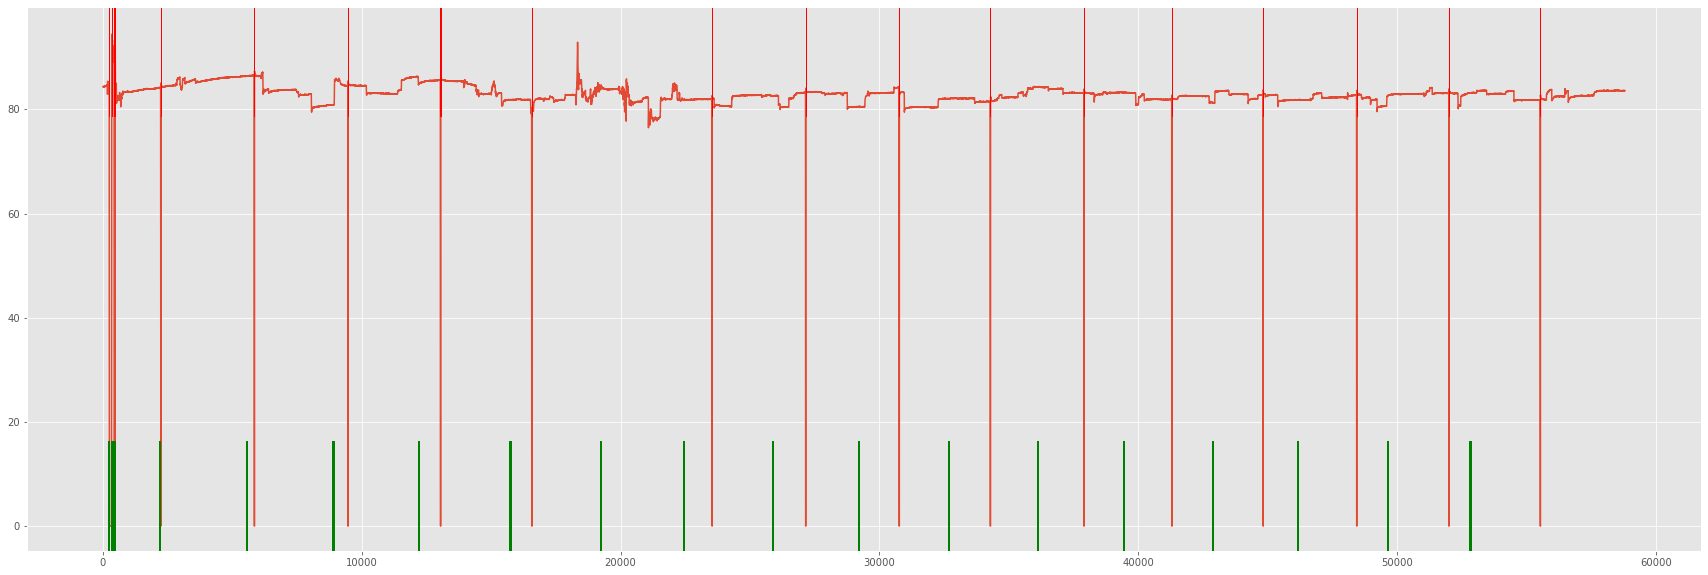

In [15]:
for vid in range(len(vidnames)):
    plt.figure(figsize=[30,10])
    plt.plot(frame_val_list[vid][0],frame_val_list[vid][1])
    for i in list(validated_off_list[vid]):
        plt.axvline(i, linewidth=1, color='r', ymin=0.8)
    for i in list(mutual_validated):
        plt.axvline(i,linewidth=2,color='g',ymax=0.2)

In [16]:
    validated_dict = {}
    for vid in range(len(vidnames)):
        validated_dict[vidnames[vid]] = pd.Series(validated_off_list[vid],dtype=int)
    data_export = pd.DataFrame(validated_dict)
    data_export.to_csv(r'D:\AzulaTrials_30_12_2020\Trial3_VisualStim_Landscapes\eye_tracking_led_off_frames.csv')

In [17]:
data_export


,AzulaTrial5_30_12L,AzulaTrial5_30_12
0,243,242.0
1,327,327.0
2,441,440.0
3,442,441.0
4,459,459.0
5,460,460.0
6,2191,2227.0
7,2198,2235.0
8,5561,5844.0
9,5569,5852.0
